# 1. Imports + seed

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
np.random.seed(0)

# 2. Synthetic dataset (5 classes)

Full dataset shape: (1000, 2) (1000,)


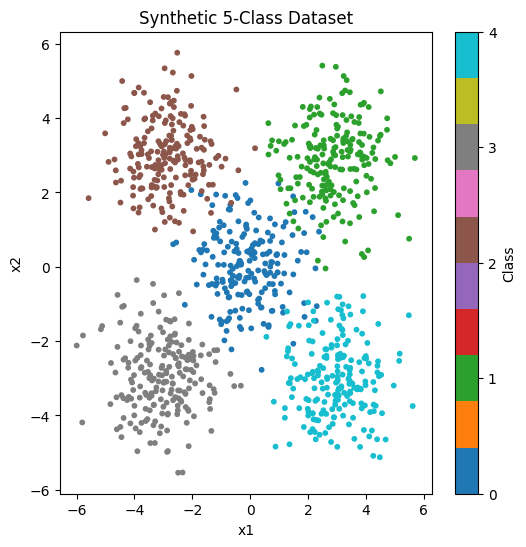

In [10]:
def generate_data(n_per_class=200, random_state=0):
    """
    Generate a simple 2D dataset with 5 Gaussian blobs (5 classes).
    Each class is centered at a different point in 2D space.

    Parameters
    ----------
    n_per_class : int
        Number of samples per class.
    random_state : int
        Seed for reproducibility.

    Returns
    -------
    X : ndarray of shape (N, 2)
        Input features.
    y : ndarray of shape (N,)
        Class labels (0, 1, 2, 3, 4).
    """
    rng = np.random.RandomState(random_state)
    
    # 5 centers in 2D: one in the middle of each quadrant + center
    centers = np.array([
        [0.0,  0.0],
        [3.0,  3.0],
        [-3.0, 3.0],
        [-3.0, -3.0],
        [3.0, -3.0],
    ])
    
    X_list = []
    y_list = []
    
    for class_idx, c in enumerate(centers):
        # Sample points around each center (Gaussian noise)
        X_c = rng.randn(n_per_class, 2) + c
        y_c = np.full(n_per_class, class_idx)  # integer labels for class_idx
        X_list.append(X_c)
        y_list.append(y_c)
    
    X = np.vstack(X_list)   # shape (N, 2)
    y = np.concatenate(y_list)  # shape (N,)
    return X, y


# Generate data
X, y = generate_data(n_per_class=200, random_state=0)

print("Full dataset shape:", X.shape, y.shape)

# Visualize the dataset
plt.figure(figsize=(6, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap="tab10", s=10)
plt.title("Synthetic 5-Class Dataset")
plt.xlabel("x1")
plt.ylabel("x2")
plt.colorbar(scatter, ticks=[0, 1, 2, 3, 4], label="Class")
plt.show()

# 3. Train-test split

In [11]:
def train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split dataset into train and test sets using random shuffling.

    Parameters
    ----------
    X : ndarray (N, D)
        Input features.
    y : ndarray (N,)
        Integer class labels.
    test_size : float
        Fraction of data to use for testing.
    random_state : int
        Seed for reproducibility.

    Returns
    -------
    X_train, X_test, y_train, y_test
    """
    rng = np.random.RandomState(random_state)
    n = X.shape[0]
    indices = np.arange(n)
    rng.shuffle(indices)
    
    test_n = int(n * test_size)
    test_idx = indices[:test_n]
    train_idx = indices[test_n:]
    
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (800, 2) (800,)
Test shape: (200, 2) (200,)


# 4. One-hot encoding

In [12]:

def one_hot(y, num_classes=5):
    """
    Convert integer labels y (shape: [N]) into one-hot vectors (shape: [N, num_classes]).

    Example: y = [2, 0, 4], num_classes=5
    -> [[0,0,1,0,0],
        [1,0,0,0,0],
        [0,0,0,0,1]]
    """
    m = y.shape[0]  # number of samples
    Y = np.zeros((m, num_classes))
    Y[np.arange(m), y] = 1
    return Y

num_classes = 5
Y_train = one_hot(y_train, num_classes=num_classes)
Y_test_onehot = one_hot(y_test, num_classes=num_classes)

print("Y_train shape:", Y_train.shape)

Y_train shape: (800, 5)


# 5. 3-layer NN (manual numpy)

In [13]:
class NeuralNetwork(object):
    """
    3-hidden-layer Neural Network for 5-class classification.

    Architecture:
    Input (D) -> Dense -> ReLU
                 -> Dense -> ReLU
                 -> Dense -> ReLU
                 -> Dense -> Softmax (5 outputs)

    Loss: Categorical Cross-Entropy
          L = - (1/m) * Σ Σ y_{i,k} * log(ŷ_{i,k})
    """

    def __init__(self, input_dim, h1=64, h2=32, h3=16, num_classes=5, learning_rate=0.01):
        """
        Initialize network parameters (weights and biases).

        Parameters
        ----------
        input_dim : int
            Number of input features (D).
        h1, h2, h3 : int
            Number of neurons in hidden layers 1, 2, 3.
        num_classes : int
            Number of output classes.
        learning_rate : float
            Learning rate for gradient descent.
        """
        self.learning_rate = learning_rate
        
        # He initialization for ReLU layers: W ~ N(0, 2 / fan_in)
        self.W1 = np.random.randn(input_dim, h1) * np.sqrt(2.0 / input_dim)
        self.b1 = np.zeros((1, h1))
        
        self.W2 = np.random.randn(h1, h2) * np.sqrt(2.0 / h1)
        self.b2 = np.zeros((1, h2))
        
        self.W3 = np.random.randn(h2, h3) * np.sqrt(2.0 / h2)
        self.b3 = np.zeros((1, h3))
        
        self.W4 = np.random.randn(h3, num_classes) * np.sqrt(2.0 / h3)
        self.b4 = np.zeros((1, num_classes))

    # ---------- Activation functions ----------
    def relu(self, x, der=False):
        """
        ReLU activation function.

        ReLU(x) = max(0, x)
        dReLU/dx = 1 if x > 0 else 0
        """
        if der:
            return (x > 0).astype(float)  # derivative of ReLU
        return np.maximum(0, x)

    def softmax(self, z):
        """
        Softmax function for multi-class output:

        softmax(z_i) = exp(z_i) / Σ_j exp(z_j)

        We subtract max(z) for numerical stability.
        """
        z_shift = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z_shift)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    # ---------- Forward pass ----------
    def feedForward(self, X):
        """
        Forward propagation:

        X -> W1,b1 -> z1 -> a1
          -> W2,b2 -> z2 -> a2
          -> W3,b3 -> z3 -> a3
          -> W4,b4 -> z4 -> softmax -> y_hat
        """
        self.X = X  # save input for backpropagation
        
        # Layer 1
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.relu(self.z1)
        
        # Layer 2
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.relu(self.z2)
        
        # Layer 3
        self.z3 = np.dot(self.a2, self.W3) + self.b3
        self.a3 = self.relu(self.z3)
        
        # Output layer
        self.z4 = np.dot(self.a3, self.W4) + self.b4
        self.y_hat = self.softmax(self.z4)  # predicted probabilities (N, num_classes)
        
        return self.y_hat

    # ---------- Loss ----------
    def compute_loss(self, Y_true_onehot):
        """
        Categorical cross-entropy loss:

        L = - (1/m) Σ Σ y_{i,k} log(ŷ_{i,k})
        """
        m = Y_true_onehot.shape[0]
        eps = 1e-15  # to avoid log(0)
        y_hat_clipped = np.clip(self.y_hat, eps, 1 - eps)
        loss = -np.sum(Y_true_onehot * np.log(y_hat_clipped)) / m
        return loss

    # ---------- Backward pass (Backpropagation) ----------
    def backPropagation(self, Y_true_onehot):
        """
        Backpropagation to compute gradients and update weights.

        For softmax + cross-entropy, the gradient at the output layer is:
            dL/dz4 = (y_hat - Y_true) / m
        """
        m = Y_true_onehot.shape[0]
        
        # Output layer gradient
        dz4 = (self.y_hat - Y_true_onehot) / m       # (N, num_classes)
        dW4 = np.dot(self.a3.T, dz4)                 # (h3, num_classes)
        db4 = np.sum(dz4, axis=0, keepdims=True)     # (1, num_classes)
        
        # Backpropagate to 3rd hidden layer
        da3 = np.dot(dz4, self.W4.T)                 # (N, h3)
        dz3 = da3 * self.relu(self.z3, der=True)     # (N, h3)
        dW3 = np.dot(self.a2.T, dz3)                 # (h2, h3)
        db3 = np.sum(dz3, axis=0, keepdims=True)     # (1, h3)
        
        # Backpropagate to 2nd hidden layer
        da2 = np.dot(dz3, self.W3.T)                 # (N, h2)
        dz2 = da2 * self.relu(self.z2, der=True)     # (N, h2)
        dW2 = np.dot(self.a1.T, dz2)                 # (h1, h2)
        db2 = np.sum(dz2, axis=0, keepdims=True)     # (1, h2)
        
        # Backpropagate to 1st hidden layer
        da1 = np.dot(dz2, self.W2.T)                 # (N, h1)
        dz1 = da1 * self.relu(self.z1, der=True)     # (N, h1)
        dW1 = np.dot(self.X.T, dz1)                  # (D, h1)
        db1 = np.sum(dz1, axis=0, keepdims=True)     # (1, h1)
        
        # Gradient descent parameter updates
        lr = self.learning_rate
        self.W4 -= lr * dW4
        self.b4 -= lr * db4
        self.W3 -= lr * dW3
        self.b3 -= lr * db3
        self.W2 -= lr * dW2
        self.b2 -= lr * db2
        self.W1 -= lr * dW1
        self.b1 -= lr * db1

    # ---------- Training loop ----------
    def train(self, X, Y_true_onehot, epochs=1000, print_every=100):
        """
        Train the network for a fixed number of epochs using batch gradient descent.

        Parameters
        ----------
        X : ndarray (N, D)
            Training input features.
        Y_true_onehot : ndarray (N, C)
            One-hot encoded labels.
        epochs : int
            Number of passes through the entire training set.
        print_every : int
            Frequency of printing loss and accuracy.
        """
        history_loss = []
        history_acc  = []
        
        for epoch in range(epochs):
            # Forward pass
            y_hat = self.feedForward(X)
            # Compute loss
            loss = self.compute_loss(Y_true_onehot)
            # Backward pass + parameter update
            self.backPropagation(Y_true_onehot)
            
            # Track metrics
            history_loss.append(loss)
            preds = np.argmax(y_hat, axis=1)
            labels = np.argmax(Y_true_onehot, axis=1)
            acc = np.mean(preds == labels)
            history_acc.append(acc)
            
            if (epoch + 1) % print_every == 0:
                print(f"Epoch {epoch+1:4d} | loss = {loss:.4f} | acc = {acc:.4f}")
        
        return history_loss, history_acc

    def predict(self, X):
        """
        Predict class labels for new data.

        Returns
        -------
        y_pred : ndarray (N,)
            Predicted class indices.
        probs : ndarray (N, num_classes)
            Predicted probabilities.
        """
        probs = self.feedForward(X)
        y_pred = np.argmax(probs, axis=1)
        return y_pred, probs

# 6. Initialize and train the network

Epoch   50 | loss = 0.3051 | acc = 0.8625
Epoch  100 | loss = 0.2476 | acc = 0.8988
Epoch  150 | loss = 0.2105 | acc = 0.9225
Epoch  200 | loss = 0.1812 | acc = 0.9363
Epoch  250 | loss = 0.1551 | acc = 0.9500
Epoch  300 | loss = 0.1317 | acc = 0.9625
Epoch  350 | loss = 0.1139 | acc = 0.9675
Epoch  400 | loss = 0.0997 | acc = 0.9738
Epoch  450 | loss = 0.0887 | acc = 0.9762
Epoch  500 | loss = 0.0799 | acc = 0.9788


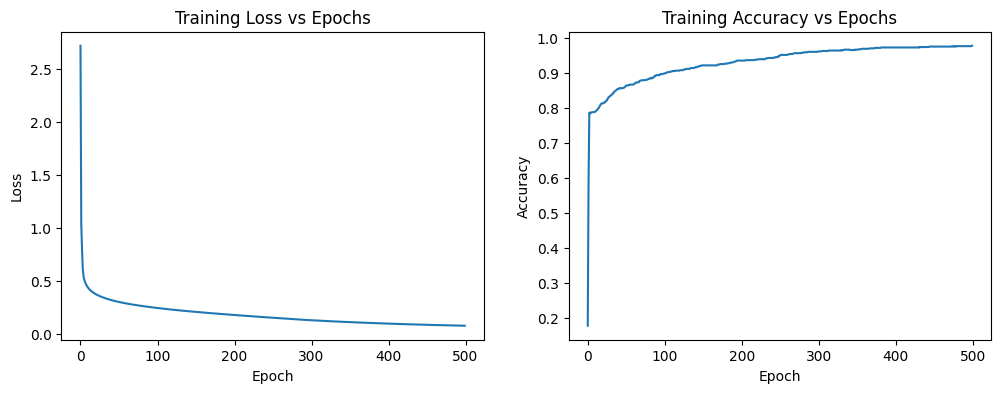

In [14]:

input_dim = X_train.shape[1]   # 2 features
num_classes = 5

# You can experiment with h1, h2, h3 and learning_rate
NN = NeuralNetwork(
    input_dim=input_dim,
    h1=64,
    h2=32,
    h3=16,
    num_classes=num_classes,
    learning_rate=0.05
)

epochs = 500  # you can try 300, 500, 1000 etc.
loss_history, acc_history = NN.train(X_train, Y_train, epochs=epochs, print_every=50)

# Plot training loss and accuracy over epochs
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(loss_history)
plt.title("Training Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(acc_history)
plt.title("Training Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

# 7. Evaluation: Accuracy, Precision, Recall, F1, Confusion Matrix

In [15]:
def classification_metrics(y_true, y_pred, num_classes=5):
    """
    Compute per-class and macro-averaged precision, recall, F1, and overall accuracy.

    Precision_k = TP_k / (TP_k + FP_k)
    Recall_k    = TP_k / (TP_k + FN_k)
    F1_k        = 2 * precision_k * recall_k / (precision_k + recall_k)
    """
    metrics = {}
    
    for k in range(num_classes):
        # True Positive (TP): predicted k and actual k
        tp = np.sum((y_true == k) & (y_pred == k))
        # False Positive (FP): predicted k but actual not k
        fp = np.sum((y_true != k) & (y_pred == k))
        # False Negative (FN): actual k but predicted not k
        fn = np.sum((y_true == k) & (y_pred != k))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
        
        metrics[k] = {
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "support": int(np.sum(y_true == k))
        }
    
    # Macro averages (simple average of per-class values)
    precisions = [m["precision"] for m in metrics.values()]
    recalls    = [m["recall"] for m in metrics.values()]
    f1s        = [m["f1"] for m in metrics.values()]
    
    metrics["macro_avg"] = {
        "precision": float(np.mean(precisions)),
        "recall": float(np.mean(recalls)),
        "f1": float(np.mean(f1s)),
    }
    metrics["accuracy"] = float(np.mean(y_true == y_pred))
    
    return metrics

In [16]:
def confusion_matrix(y_true, y_pred, num_classes=5):
    """
    Compute confusion matrix: rows = true labels, columns = predicted labels.
    """
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

In [17]:
# Predict on test data
y_pred_test, probs_test = NN.predict(X_test)

In [18]:
# Metrics
metrics = classification_metrics(y_test, y_pred_test, num_classes=num_classes)
print("Overall accuracy:", metrics["accuracy"])
print("Macro-averaged precision:", metrics["macro_avg"]["precision"])
print("Macro-averaged recall:", metrics["macro_avg"]["recall"])
print("Macro-averaged F1:", metrics["macro_avg"]["f1"])

print("\nPer-class metrics:")
for k in range(num_classes):
    print(f"Class {k}: "
          f"precision={metrics[k]['precision']:.3f}, "
          f"recall={metrics[k]['recall']:.3f}, "
          f"f1={metrics[k]['f1']:.3f}, "
          f"support={metrics[k]['support']}")

Overall accuracy: 0.96
Macro-averaged precision: 0.9582020202020203
Macro-averaged recall: 0.9562346437346438
Macro-averaged F1: 0.957076281794549

Per-class metrics:
Class 0: precision=0.879, recall=0.879, f1=0.879, support=33
Class 1: precision=0.940, recall=0.979, f1=0.959, support=48
Class 2: precision=0.972, recall=0.946, f1=0.959, support=37
Class 3: precision=1.000, recall=1.000, f1=1.000, support=38
Class 4: precision=1.000, recall=0.977, f1=0.989, support=44


In [19]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test, num_classes=num_classes)
print("\nConfusion matrix:\n", cm)


Confusion matrix:
 [[29  3  1  0  0]
 [ 1 47  0  0  0]
 [ 2  0 35  0  0]
 [ 0  0  0 38  0]
 [ 1  0  0  0 43]]


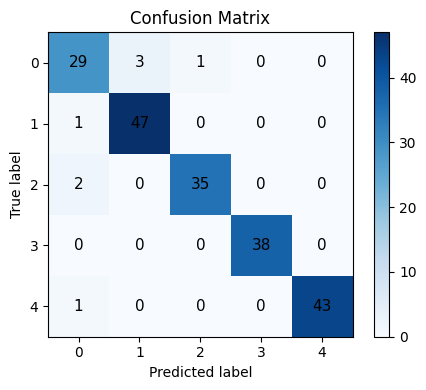

In [23]:
# Visualize confusion matrix
plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, list(range(num_classes)))
plt.yticks(tick_marks, list(range(num_classes)))

plt.xlabel("Predicted label")
plt.ylabel("True label")

# Put counts on the matrix
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="black", fontsize=11)

plt.tight_layout()
plt.show()